In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cx_Oracle as cxo
import getpass as gp

%matplotlib inline

### Create an EDW connection  

In [2]:
conn = cxo.connect(user=gp.getuser(),password=gp.getpass("EDW passord: "),dsn="edw.co.ihc.com",encoding="UTF-8")

EDW passord: ········


In [3]:
query = """select height, weight 
            from cerner_dm.med_admin 
            where 1 = 1
                and height is not null 
                and height > 1
                and height < 3
                and weight is not null 
                and weight < 400
                and admit_age_yrs >= 18
                and rownum < 50000"""
#there are some errors in this data set, hence all of the WHERE clauses....

### Pull height and weight into a dataframe  

In [4]:
height_weight_df = pd.read_sql(query, con = conn)

In [5]:
height_weight_df.head(10)

,HEIGHT,WEIGHT
0,1.650,73.9
1,1.570,89.8
2,1.778,160.2
3,1.527,65.3
4,1.530,98.2
5,1.700,82.0
6,1.930,80.0
7,1.670,77.0
8,1.651,89.9
9,1.600,49.0


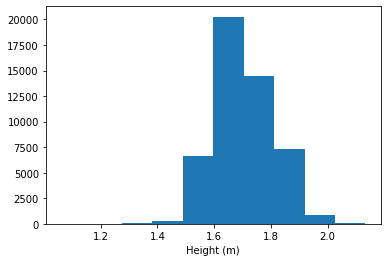

In [6]:
plt.hist(height_weight_df.HEIGHT)
plt.xlabel('Height (m)')
plt.show()

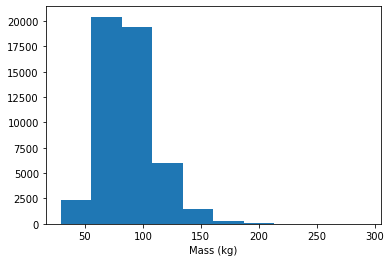

In [7]:
plt.hist(height_weight_df.WEIGHT)
plt.xlabel('Mass (kg)')
plt.show()

### Calulate BMI:

In [8]:
BMI = np.divide(height_weight_df.WEIGHT, np.square(height_weight_df.HEIGHT))

In [9]:
BMI.max() #clearly an error, but this is deterministic, so not a huge deal....

142.53269637403088

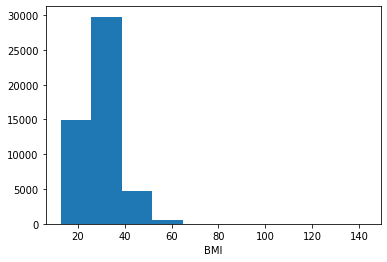

In [10]:
plt.hist(BMI)
plt.xlabel('BMI')
plt.show()

### Create a bunch of noise variables

In [11]:
n_obs = height_weight_df.shape[0] #number of observations to simulate

In [12]:
rand_norm = np.random.randn(n_obs)

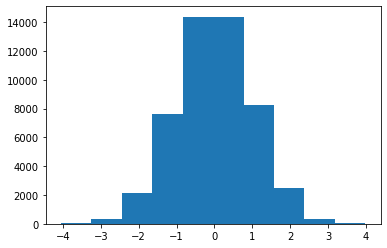

In [13]:
plt.hist(rand_norm)
plt.show()

In [14]:
rand_unif = rand_norm = np.random.rand(n_obs)

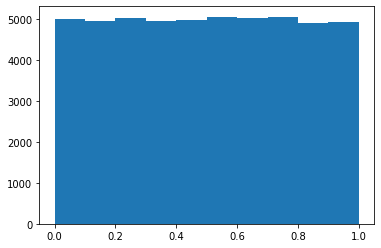

In [15]:
plt.hist(rand_unif)
plt.show()

In [16]:
rand_beta1 = rand_norm = np.random.beta(2,5,n_obs)

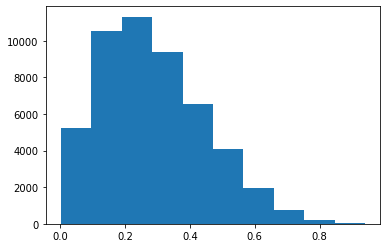

In [17]:
plt.hist(rand_beta1)
plt.show()

In [18]:
rand_beta2 = rand_norm = np.random.beta(5,2,n_obs)

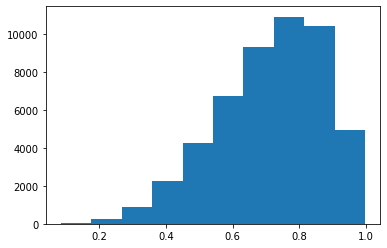

In [19]:
plt.hist(rand_beta2)
plt.show()

In [20]:
random_cols = pd.DataFrame(np.column_stack((rand_norm,rand_unif,rand_beta1,rand_beta2)))

In [21]:
random_cols.head(10)

,0,1,2,3
0,0.563141,0.122582,0.142643,0.563141
1,0.610088,0.152015,0.251122,0.610088
2,0.514373,0.626635,0.279394,0.514373
3,0.424026,0.354995,0.346689,0.424026
4,0.908311,0.519609,0.330836,0.908311
5,0.962230,0.363036,0.168275,0.962230
6,0.530518,0.423524,0.390682,0.530518
7,0.569933,0.699284,0.319644,0.569933
8,0.772230,0.998220,0.510385,0.772230
9,0.822755,0.737346,0.632889,0.822755


### Append these new varaibles to the previous data

In [22]:
new_df = pd.concat((height_weight_df,random_cols),axis=1)

In [23]:
new_df.head(10)

,HEIGHT,WEIGHT,0,1,2,3
0,1.650,73.9,0.563141,0.122582,0.142643,0.563141
1,1.570,89.8,0.610088,0.152015,0.251122,0.610088
2,1.778,160.2,0.514373,0.626635,0.279394,0.514373
3,1.527,65.3,0.424026,0.354995,0.346689,0.424026
4,1.530,98.2,0.908311,0.519609,0.330836,0.908311
5,1.700,82.0,0.962230,0.363036,0.168275,0.962230
6,1.930,80.0,0.530518,0.423524,0.390682,0.530518
7,1.670,77.0,0.569933,0.699284,0.319644,0.569933
8,1.651,89.9,0.772230,0.998220,0.510385,0.772230
9,1.600,49.0,0.822755,0.737346,0.632889,0.822755


define R-squared for keras:

In [24]:
def R_Squared(y_true, y_pred):
    from tensorflow.keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

### run model, but with the noise variables thrown in

In [26]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(16, activation=tf.nn.relu,input_shape = (6,)))
model.add(tf.keras.layers.Dense(16, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer = 'adam',loss = 'mean_squared_error',metrics=[R_Squared])

model.fit(new_df,BMI,batch_size = 32,epochs = 15)

Epoch 1/15
49999/49999 [==============================] - 3s 68us/sample - loss: 18.0378 - R_Squared: 0.5842
Epoch 2/15
49999/49999 [==============================] - 2s 46us/sample - loss: 13.0373 - R_Squared: 0.7068
Epoch 3/15
49999/49999 [==============================] - 2s 42us/sample - loss: 12.5569 - R_Squared: 0.7197
Epoch 4/15
49999/49999 [==============================] - 2s 42us/sample - loss: 12.2598 - R_Squared: 0.7285
Epoch 5/15
49999/49999 [==============================] - 2s 40us/sample - loss: 11.8032 - R_Squared: 0.7395
Epoch 6/15
49999/49999 [==============================] - 2s 40us/sample - loss: 11.0871 - R_Squared: 0.7556
Epoch 7/15
49999/49999 [==============================] - 2s 40us/sample - loss: 9.5923 - R_Squared: 0.7903
Epoch 8/15
49999/49999 [==============================] - 2s 40us/sample - loss: 6.9876 - R_Squared: 0.8476
Epoch 9/15
49999/49999 [==============================] - 2s 50us/sample - loss: 3.6710 - R_Squared: 0.9228
Epoch 10/15
49999/4999

The performance great--despite the presence of variables that add no value.
It is able to create an excellent facsimile of a transformation!